In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-05-01T20:24:02.335542+03:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.21.0

Compiler    : GCC 13.2.1 20240210
OS          : Linux
Release     : 6.8.8-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных


In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)

        area = requests.get(f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-05-01: 100%|██████████| 901/901 [02:57<00:00,  5.08it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
4572,#bcaaa4,557.340964,0.092,unspecified,2024-05-01 00:27:41
4573,#0f9d58,43262.254672,7.166,liberated,2024-05-01 00:27:41
4574,#ff5252,139991.513798,23.189,other_territories,2024-05-01 00:27:41
4575,#880e4f,43974.034421,7.284,occupied_to_24_02_2022,2024-05-01 00:27:41


In [4]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [5]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [6]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [7]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_18787/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [8]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-05-01                    liberated
2024-05-01    occupied_after_24_02_2022
2024-05-01       occupied_to_24_02_2022
2024-05-01            other_territories
2024-05-01                  unspecified
Name: type, Length: 3384, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [9]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [10]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [11]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa

,area
2022-04-03,63714.938326
2022-04-04,64256.540524
2022-04-05,64193.626525
2022-04-06,64261.353774
2022-04-07,65046.306239
...,...
2024-04-27,64812.969958
2024-04-28,64818.085841
2024-04-29,64850.564141
2024-04-30,64860.309930


In [12]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")
xx

,ru_holiday,ua_holiday
2022-04-03,0,0
2022-04-04,0,0
2022-04-05,0,0
2022-04-06,0,0
2022-04-07,0,0
...,...,...
2024-04-27,0,0
2024-04-28,0,0
2024-04-29,0,0
2024-04-30,0,0


In [13]:
best_model = None
for p in range(5):
    for d in range(2):
        for q in range(5):
            mod = ARIMA(aa, order=(p, d, q)).fit()
            if best_model is None or best_model.aic > mod.aic:
                best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/ven

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  760
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -5025.626
Date:                Wed, 01 May 2024   AIC                          10069.253
Time:                        20:27:17   BIC                          10110.953
Sample:                    04-03-2022   HQIC                         10085.311
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.824e+04      0.216   3.16e+05      0.000    6.82e+04    6.82e+04
ar.L1          1.5072      0.022     69.080      0.000       1.464       1.550
ar.L2         -1.3907      0.031    -44.422      0.000      -1.452      -1.329
ar.L3          1.4750      0.020     72.336      0.000       1.435       1.515
ar.L4         -0.5917      0.011    -51.660      0.000      -0.614      -0.569
ma.L1          0.3557      0.025     14.342      0.000       0.307       0.404
ma.L2          0.9012      0.028     31.909      0.000       0.846       0.957
ma.L3          0.1631      0.028      5.876      0.000       0.109       0.217
sigma2      2.977e+04    345.645     86.142      0.000    2.91e+04    3.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             77885.13
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+19. Standard errors may be unstable.
"""

In [14]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-05-02,64879.594723,172.552743,64541.397560,65217.791886
2024-05-03,64887.710466,364.828912,64172.658937,65602.761994
2024-05-04,64891.942831,541.394313,63830.829476,65953.056187
2024-05-05,64893.108238,696.707212,63527.587195,66258.629281
2024-05-06,64895.496926,844.155915,63240.981735,66550.012118
...,...,...,...,...
2024-08-25,65000.362737,5577.608998,54068.449982,75932.275493
2024-08-26,65001.307292,5601.405807,54022.753647,75979.860937
2024-08-27,65002.325238,5625.154560,53977.224894,76027.425583
2024-08-28,65003.180915,5648.730429,53931.872717,76074.489113


In [15]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha / 100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

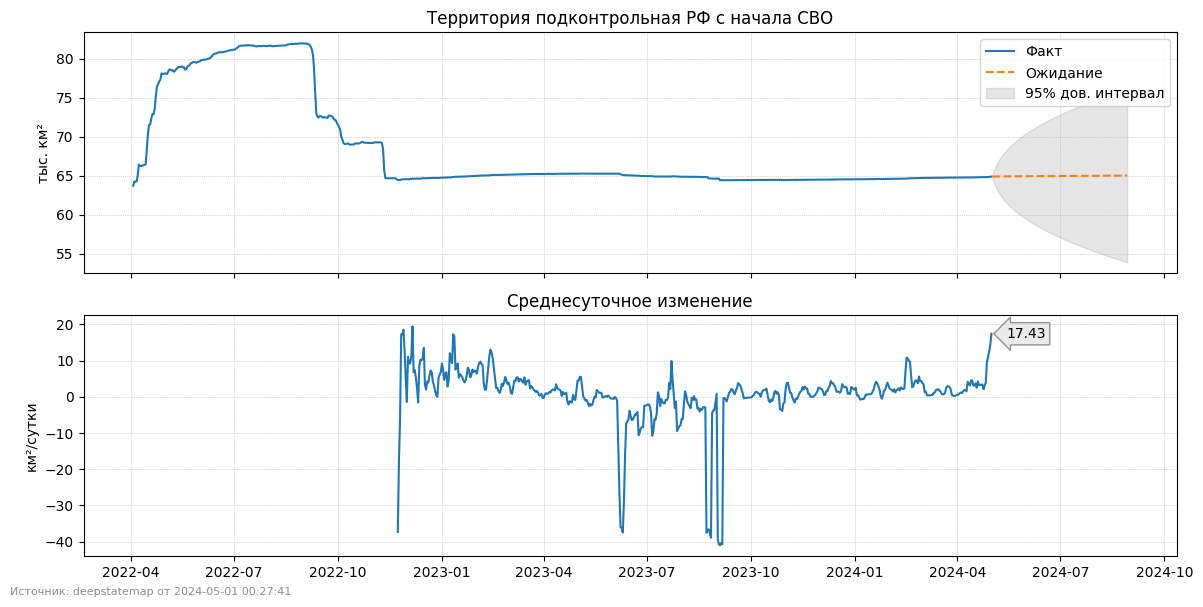

In [16]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True, min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area,
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=12 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)